# Classification with 2017 and 2018 team stats

In this notebook, we will perform classification with the team statistics data from the 2016-2017 and 2017-2018 season. More specifically, we will apply first apply a PCA with 7 components on 2016-2017 team data. We will then train the transformed on some of the 2016-2017 data using different machine learning classification techniques. We will try to find the classification algorithm that when trained on the 2016-2017 data, has the greatest accuracy and smallest training time. The following table summarizes what we will find in this notebook.

| Method | Approximate Training time | '16-'17 percent accuracy | '17-'18 percent accuracy |
| :-----------------------------------------: | ------------------- | ----------------------------- | ------------------------- |
| Logistic Regression | $0.007$ sec | $79.0\%$ | $76.3\%$ |
| Decision Tree | $0.014$ sec | $67.2\%$ | $65.6\%$ |
| Support Vector Machine | $1$ hr $25$ min | $77.7\%$ | $75.0\%$ |
| Random Forest | $0.046$ sec | $73.4\%$ | $70.5\%$ |
| Gradient Tree Boosting | $0.934$ sec | $75.2\%$ | $72.3\%$ |
| k-Nearest Neighbors (k-NN)| $0.004$ sec | $70.5\%$ | $68.8\%$ |
| Voting (k-NN, Log. Reg., and Ran. For.) | $0.049$ sec | $76.3\%$ | $75.0\%$ | 



We begin by importing some necessary libraries.

In [1]:
% matplotlib inline

import numpy as np

import pandas as pd
pd.set_option('display.max_columns',None)
from pandas.util.testing import assert_frame_equal

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

from datetime import datetime
import time
from nose.tools import assert_equal

import sqlite3

## Collecting 2016-17 and 2017-18 team stats data

We begin by importing all of the team stats data from the 2016-17 and 2017-18 seasons. We recall that we stored the team stats data for the past 10 seasons (2009-10 and on) in the file 'all_team_stats_2009_to_2018.csv'. Unfortunately, this file does not directly contain the year in which the season occurred. We will need to use the information from the file 'all_games_04_on.csv', which contains this information. We use SQL on these two files to filter to the games occuring in the past two seasons.

In [2]:
#DataFrame of all team stats since 2009-2010 season
all_team_stats = pd.read_csv('all_team_stats_2009_to_2018.csv').loc[:,'team':]

all_team_stats.head()

,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,DAL,21,23,25,27,96,39,78,50.0,9,23,39.1,9,10,90.0,52,8,39,21,2,4,28,8,8,0,16,1,0,0,[],1,Away,281217028
1,TOR,33,16,14,23,86,36,84,42.9,4,11,36.4,10,13,76.9,39,7,30,17,7,4,12,17,8,0,14,0,0,0,[],0,Home,281217028
2,GS,26,19,17,26,88,36,90,40.0,5,21,23.8,11,13,84.6,48,10,31,13,6,6,32,6,10,38,21,1,0,0,[],0,Away,290304004
3,CHI,20,31,24,35,110,39,86,45.3,5,8,62.5,27,32,84.4,60,17,37,19,7,7,26,24,18,46,16,0,0,0,[],1,Home,290304004
4,MIL,20,19,19,15,73,28,75,37.3,4,18,22.2,13,14,92.9,46,8,33,19,7,3,36,13,10,24,23,0,0,0,[],0,Away,290304005


In [3]:
#DataFrame of info on all games since 2004-2005 season 
all_game_info = pd.read_csv('all_games_04_on.csv').loc[:,'team':]

#restrict to games during 2016-2017 season
season_17_bool = all_game_info['season_end_year'] == 2017
all_game_info_17 = all_game_info[season_17_bool]

#restrict to games during 2017-2018 season
season_18_bool = all_game_info['season_end_year'] == 2018
all_game_info_18 = all_game_info[season_18_bool]

In [4]:
print('Number of 2016-17 team stat rows: ' + str(all_game_info_17.shape[0]))

all_game_info_17.head()

Number of 2016-17 team stat rows: 2618


,team,season_start_year,season_end_year,season_type,game_month,game_day,game_year,game_date,matchup_id
28876,bos,2016,2017,regular,10,26,2016,10/26/2016,400899380
28877,bos,2016,2017,regular,10,27,2016,10/27/2016,400899422
28878,bos,2016,2017,regular,10,29,2016,10/29/2016,400899477
28879,bos,2016,2017,regular,11,2,2016,11/2/2016,400899511
28880,bos,2016,2017,regular,11,3,2016,11/3/2016,400899518


In [5]:
print('Number of 2017-18 team stat rows: ' + str(all_game_info_18.shape[0]))

all_game_info_18.head()

Number of 2017-18 team stat rows: 2624


,team,season_start_year,season_end_year,season_type,game_month,game_day,game_year,game_date,matchup_id
31336,bos,2017,2018,regular,10,17,2017,10/17/2017,400974437
31337,bos,2017,2018,regular,10,18,2017,10/18/2017,400974703
31338,bos,2017,2018,regular,10,20,2017,10/20/2017,400974772
31339,bos,2017,2018,regular,10,24,2017,10/24/2017,400974802
31340,bos,2017,2018,regular,10,26,2017,10/26/2017,400974818


We now employ SQLite to match up the Matchup ID's for each year with the corresponding team stats.

In [6]:
home_dir = !echo $HOME

#Define data directory
database_dir = home_dir[0] + '/database'

print(f'Database will persist at {database_dir}\n')

Database will persist at /Users/derekjung/database



In [7]:
%%bash -s %%bash  "$database_dir"

#passed Python variable, later accessed with $1

#check if directory exists
if [ -d "$1" ] ; then

    echo "Directory already exists."

else
    #otherwise grapb file from Internet and store locally in data directory
    
    mkdir $1
    echo "creating database directory"

fi

Directory already exists.


In [8]:
con = sqlite3.connect("stats_629.db")

cur = con.cursor()

In [9]:
#save DataFrames in tables

all_team_stats.to_sql(name='team_stats_tb', con=con, if_exists='replace', \
                     index=False, chunksize=1000)

all_game_info_17.to_sql(name='game_info_17_tb', con=con, if_exists='replace', \
                       index=False, chunksize=1000)

all_game_info_18.to_sql(name='game_info_18_tb', con=con, if_exists='replace', \
                       index=False, chunksize=1000)

We now check that the first few rows of each table looks correct.

In [10]:
#all team stats table
sql_team_stats_access = "\
SELECT * \
FROM team_stats_tb \
LIMIT 3 \
"

cur.execute(sql_team_stats_access)

for row in cur:
    print(row)

('DAL', 21, 23, 25, 27, 96, 39, 78, 50.0, 9, 23, 39.1, 9, 10, 90.0, 52, 8, 39, 21, 2, 4, 28, 8, 8, 0, 16, 1, 0, 0, '[]', 1, 'Away', 281217028)
('TOR', 33, 16, 14, 23, 86, 36, 84, 42.9, 4, 11, 36.4, 10, 13, 76.9, 39, 7, 30, 17, 7, 4, 12, 17, 8, 0, 14, 0, 0, 0, '[]', 0, 'Home', 281217028)
('GS', 26, 19, 17, 26, 88, 36, 90, 40.0, 5, 21, 23.8, 11, 13, 84.6, 48, 10, 31, 13, 6, 6, 32, 6, 10, 38, 21, 1, 0, 0, '[]', 0, 'Away', 290304004)


In [11]:
sql_game_17_access = "\
SELECT * \
FROM game_info_17_tb \
LIMIT 3\
"

cur.execute(sql_game_17_access)

for row in cur:
    print(row)

('bos', 2016, 2017, 'regular', 10, 26, 2016, '10/26/2016', 400899380)
('bos', 2016, 2017, 'regular', 10, 27, 2016, '10/27/2016', 400899422)
('bos', 2016, 2017, 'regular', 10, 29, 2016, '10/29/2016', 400899477)


In [12]:
sql_game_18_access = "\
SELECT *\
FROM game_info_18_tb \
LIMIT 3\
"

cur.execute(sql_game_18_access)

for row in cur:
    print(row)

('bos', 2017, 2018, 'regular', 10, 17, 2017, '10/17/2017', 400974437)
('bos', 2017, 2018, 'regular', 10, 18, 2017, '10/18/2017', 400974703)
('bos', 2017, 2018, 'regular', 10, 20, 2017, '10/20/2017', 400974772)


We are now to filter the team stats data to the 2016-17 and 2017-18 seasons.

In [13]:
#filter team stats for 2016-17 season

sql_game_stats_17_join = "\
SELECT DISTINCT game_tb.season_end_year, game_tb.season_type,\
game_tb.game_date, game_tb.matchup_id AS game_matchup_id, \
team_tb.*\
FROM game_info_17_tb AS game_tb \
JOIN team_stats_tb AS team_tb \
ON game_tb.matchup_id = team_tb.matchup_id \
"

team_stats_17 = pd.read_sql(sql_game_stats_17_join, con)

print('Number of team stat rows: ' + str(team_stats_17.shape[0]) + ' (2 for each distinct game)')

team_stats_17.head()

Number of team stat rows: 2618 (2 for each distinct game)


,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,2017,regular,10/26/2016,400899380,BKN,31,27,23,36,117,43,97,44.3,15,44,34.1,16,20,80.0,51,15,29,22,8,3,16,21,8,50,19,0,0,0,[],0,Away,400899380
1,2017,regular,10/26/2016,400899380,BOS,33,31,33,25,122,48,89,53.9,11,32,34.4,15,18,83.3,51,12,35,36,13,9,19,19,11,50,20,0,1,0,[],1,Home,400899380
2,2017,regular,10/27/2016,400899422,BOS,20,29,24,26,99,38,76,50.0,8,23,34.8,15,24,62.5,44,3,33,22,6,6,12,17,10,42,25,2,0,0,[],0,Away,400899422
3,2017,regular,10/27/2016,400899422,CHI,30,27,22,26,105,36,92,39.1,11,25,44.0,22,30,73.3,67,18,37,25,5,1,12,17,4,38,21,2,0,0,[],1,Home,400899422
4,2017,regular,10/29/2016,400899477,BOS,28,16,27,33,104,39,81,48.1,15,31,48.4,11,17,64.7,55,4,38,25,4,6,13,13,4,36,26,3,1,0,[],1,Away,400899477


In [14]:
#filter to team stats data for 2017-2018 season

sql_game_stats_18_join = "\
SELECT DISTINCT game_tb.season_end_year, game_tb.season_type,\
game_tb.game_date, game_tb.matchup_id AS game_matchup_id, \
team_tb.*\
FROM game_info_18_tb AS game_tb \
JOIN team_stats_tb AS team_tb \
ON game_tb.matchup_id = team_tb.matchup_id \
"

team_stats_18 = pd.read_sql(sql_game_stats_18_join, con)

print('Number of team stat rows: ' + str(team_stats_18.shape[0]) + ' (2 for each distinct game)')

team_stats_18.head()

Number of team stat rows: 2624 (2 for each distinct game)


,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,2018,regular,10/17/2017,400974437,BOS,19,19,33,28,99,36,88,40.9,8,32,25.0,19,25,76.0,52,9,37,24,11,4,12,15,16,42,24,3,0,0,[],0,Away,400974437
1,2018,regular,10/17/2017,400974437,CLE,29,25,18,30,102,38,83,45.8,5,22,22.7,21,25,84.0,55,9,41,19,3,4,17,24,11,50,25,2,0,0,[],1,Home,400974437
2,2018,regular,10/18/2017,400974703,BOS,26,27,27,20,100,39,91,42.9,11,28,39.3,11,21,52.4,54,11,32,23,12,2,15,16,6,50,27,1,0,0,[],0,Home,400974703
3,2018,regular,10/18/2017,400974703,MIL,24,34,18,32,108,38,76,50.0,7,21,33.3,25,30,83.3,51,6,39,19,6,4,15,17,4,56,22,1,0,0,[],1,Away,400974703
4,2018,regular,10/20/2017,400974772,BOS,24,22,23,33,102,35,84,41.7,10,29,34.5,22,32,68.8,64,14,41,16,4,5,19,16,0,28,24,0,0,0,[],1,Away,400974772


We conclude this section by finding the summary statistics of these team stats.

In [15]:
#summary stats of 2016-17 team stats
team_stats_17.describe()

,season_end_year,game_matchup_id,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,won,matchup_id
count,2618.0,2.618000e+03,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2.618000e+03
mean,2017.0,4.009032e+08,26.544691,26.565699,26.092819,25.735294,105.618029,39.017189,85.305577,45.841864,9.705118,27.127960,35.671658,17.878533,23.155080,77.149007,51.564935,10.110772,33.297173,22.598167,7.694423,4.742552,13.914820,16.095111,13.155844,43.514897,19.951108,0.649351,0.049656,0.055768,0.500000,4.009032e+08
std,0.0,1.240292e+04,5.890845,5.758322,5.892634,5.890465,12.165714,4.981211,7.113081,5.403226,3.520037,6.725644,9.422146,6.050715,7.235306,10.043490,7.241177,3.744918,5.291098,5.260405,2.896873,2.476522,3.884559,6.085913,6.616881,9.620143,4.212167,0.875101,0.225898,0.229517,0.500096,1.240292e+04
min,2017.0,4.008994e+08,8.000000,9.000000,8.000000,8.000000,64.000000,21.000000,61.000000,28.600000,1.000000,7.000000,5.300000,2.000000,3.000000,17.600000,29.000000,1.000000,18.000000,7.000000,0.000000,0.000000,3.000000,0.000000,0.000000,16.000000,8.000000,0.000000,0.000000,0.000000,0.000000,4.008994e+08
25%,2017.0,4.008997e+08,23.000000,23.000000,22.000000,22.000000,97.000000,36.000000,81.000000,42.100000,7.000000,22.250000,29.400000,14.000000,18.000000,71.000000,47.000000,7.000000,30.000000,19.000000,6.000000,3.000000,11.000000,12.000000,8.000000,36.000000,17.000000,0.000000,0.000000,0.000000,0.000000,4.008997e+08
50%,2017.0,4.009000e+08,27.000000,27.000000,26.000000,26.000000,106.000000,39.000000,85.000000,45.700000,9.000000,27.000000,35.500000,17.000000,23.000000,77.800000,51.000000,10.000000,33.000000,22.000000,8.000000,4.000000,14.000000,16.000000,12.000000,44.000000,20.000000,0.000000,0.000000,0.000000,0.500000,4.009000e+08
75%,2017.0,4.009004e+08,30.000000,30.000000,30.000000,30.000000,114.000000,42.000000,90.000000,49.400000,12.000000,31.000000,41.700000,22.000000,28.000000,84.000000,56.000000,13.000000,37.000000,26.000000,9.000000,6.000000,16.000000,20.000000,17.000000,50.000000,23.000000,1.000000,0.000000,0.000000,1.000000,4.009004e+08
max,2017.0,4.009545e+08,49.000000,44.000000,50.000000,47.000000,149.000000,57.000000,128.000000,64.000000,25.000000,61.000000,70.000000,42.000000,53.000000,100.000000,81.000000,26.000000,51.000000,47.000000,20.000000,15.000000,29.000000,42.000000,53.000000,78.000000,39.000000,7.000000,2.000000,1.000000,1.000000,4.009545e+08


In [16]:
#summary stats of 2017-18 team stats
team_stats_18.describe()

,season_end_year,game_matchup_id,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,won,matchup_id
count,2624.0,2.624000e+03,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.00000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2.624000e+03
mean,2018.0,4.009789e+08,26.709985,26.767530,26.320122,25.848323,106.215320,39.530869,85.946265,46.084108,10.491616,29.056784,36.052325,16.661966,21.725610,76.82359,51.479040,9.679116,33.795351,23.147485,7.690930,4.815549,14.196646,16.330412,12.118902,44.974848,19.907774,0.599466,0.045351,0.049543,0.500000,4.009789e+08
std,0.0,1.347471e+04,5.879729,5.727055,5.890056,5.796315,12.037515,5.102887,6.872995,5.479613,3.544490,6.666174,9.043003,5.812654,7.098738,10.48368,7.071414,3.644612,5.291614,5.218589,2.918407,2.505254,3.784438,6.072084,6.509353,9.619017,4.187544,0.843002,0.208112,0.217040,0.500095,1.347471e+04
min,2018.0,4.009744e+08,7.000000,6.000000,8.000000,8.000000,69.000000,22.000000,66.000000,28.200000,1.000000,11.000000,5.600000,1.000000,1.000000,14.30000,29.000000,0.000000,18.000000,9.000000,0.000000,0.000000,3.000000,0.000000,0.000000,16.000000,8.000000,0.000000,0.000000,0.000000,0.000000,4.009744e+08
25%,2018.0,4.009751e+08,23.000000,23.000000,22.000000,22.000000,98.000000,36.000000,81.000000,42.300000,8.000000,24.000000,30.000000,12.000000,17.000000,70.30000,46.000000,7.000000,30.000000,19.000000,6.000000,3.000000,11.000000,12.000000,7.000000,38.000000,17.000000,0.000000,0.000000,0.000000,0.000000,4.009751e+08
50%,2018.0,4.009754e+08,27.000000,27.000000,26.000000,26.000000,106.000000,39.000000,86.000000,46.000000,10.000000,29.000000,36.000000,16.000000,21.000000,77.40000,51.000000,9.000000,34.000000,23.000000,7.000000,5.000000,14.000000,16.000000,11.000000,44.000000,20.000000,0.000000,0.000000,0.000000,0.500000,4.009754e+08
75%,2018.0,4.009757e+08,31.000000,31.000000,30.000000,30.000000,114.000000,43.000000,91.000000,49.500000,13.000000,33.000000,42.125000,20.000000,26.000000,84.00000,56.000000,12.000000,37.000000,27.000000,10.000000,6.000000,17.000000,20.000000,16.000000,52.000000,23.000000,1.000000,0.000000,0.000000,1.000000,4.009757e+08
max,2018.0,4.010346e+08,49.000000,45.000000,50.000000,48.000000,149.000000,58.000000,114.000000,66.700000,24.000000,59.000000,71.400000,41.000000,64.000000,100.00000,79.000000,24.000000,56.000000,46.000000,18.000000,16.000000,29.000000,40.000000,48.000000,82.000000,42.000000,5.000000,1.000000,1.000000,1.000000,4.010346e+08


## PCA with components on team stats

We now have two DataFrames: the team stats data for all games during the 2016-2017 season and the same for the 2017-2018 season. The 2016-17 DataFrame has the team stats for 1309 games while the 2017-18 DataFrame has them for 1312 games.

We will run Principal Component Analysis on these two DataFrames, keeping some number of principal components. We will take into account all of the team stats, from `first_qtr_points` to `flagrant_fouls`. We will fit our PCA to the 2016-2017 team stats data. We will then transform the data on the past two seasons to this fitted PCA model. The exact number of components we consider will depend on how much variance we wish to explain relative to the complexity of our data.

We begin by extracting the numerical stats from the two team stats DataFrames. 

In [17]:
#all column names (including season end year)
all_stat_names = team_stats_17.columns.tolist()

#find indices for first qtr points and flagrant fouls
first_qtr_points_idx = all_stat_names.index('first_qtr_points')
flagrant_fouls_idx = all_stat_names.index('flagrant_fouls')

#stat names for numerical stats
num_stat_names = all_stat_names[first_qtr_points_idx: flagrant_fouls_idx+1]

In [18]:
#extract 2016-17 numerical team stats data
num_team_stats_17 = team_stats_17[num_stat_names]

#2017-18 numerical team stats data
num_team_stats_18 = team_stats_18[num_stat_names]

In [19]:
#check first few rows of restricted 2016-17 team stats
num_team_stats_17.head()

,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls
0,31,27,23,36,117,43,97,44.3,15,44,34.1,16,20,80.0,51,15,29,22,8,3,16,21,8,50,19,0,0
1,33,31,33,25,122,48,89,53.9,11,32,34.4,15,18,83.3,51,12,35,36,13,9,19,19,11,50,20,0,1
2,20,29,24,26,99,38,76,50.0,8,23,34.8,15,24,62.5,44,3,33,22,6,6,12,17,10,42,25,2,0
3,30,27,22,26,105,36,92,39.1,11,25,44.0,22,30,73.3,67,18,37,25,5,1,12,17,4,38,21,2,0
4,28,16,27,33,104,39,81,48.1,15,31,48.4,11,17,64.7,55,4,38,25,4,6,13,13,4,36,26,3,1


In [20]:
from sklearn.decomposition import PCA

#conduct PCA to understand how much variance explained with components
pca_exploring = PCA()

#fit PCA to '16-'17 team stats
pca_exploring.fit(num_team_stats_17)

#explained variance of components
exp_vars = pca_exploring.explained_variance_ratio_

print('Variance: Projected dimension')
print('-----------------------------')

for idx, row in enumerate(pca_exploring.components_):
    output = '{0:4.1f}%:     '.format(100.0*exp_vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) \
                        for val, name in zip(row, num_stat_names))
    print(output + '\n')

Variance: Projected dimension
-----------------------------
27.7%:      0.18 * first_qtr_points +  0.16 * second_qtr_points +  0.17 * third_qtr_points +  0.15 * fourth_qtr_points +  0.69 * total_points +  0.25 * fg_made +  0.11 * fg_attempted +  0.23 * fg_percentage +  0.10 * threept_made +  0.08 * threept_attempted +  0.29 * threept_percentage +  0.09 * ft_made +  0.09 * ft_attempted +  0.11 * ft_percentage +  0.04 * total_rebounds + -0.00 * offensive_rebounds +  0.04 * defensive_rebounds +  0.19 * assists +  0.02 * steals +  0.01 * blocks + -0.02 * total_turnovers + -0.01 * points_off_turnovers +  0.16 * fast_break_points +  0.28 * points_in_paint +  0.03 * personal_fouls +  0.00 * technical_fouls +  0.00 * flagrant_fouls

13.1%:     -0.02 * first_qtr_points + -0.03 * second_qtr_points +  0.00 * third_qtr_points + -0.03 * fourth_qtr_points + -0.04 * total_points +  0.11 * fg_made +  0.38 * fg_attempted + -0.07 * fg_percentage + -0.12 * threept_made + -0.03 * threept_attempted + -0.42

In [21]:
#print cumulative explained variances by number of principal components
cum_exp_vars = []

#total number of principal components
num_cmpts = pca_exploring.explained_variance_ratio_.shape[0]

for idx in range(num_cmpts):
    if idx == 0: #first include variance of first component
        cum_exp_vars.append(100 * pca_exploring.explained_variance_ratio_[0])
    else:
        cum_exp_vars.append(cum_exp_vars[idx-1] + 100 * pca_exploring.explained_variance_ratio_[idx])

for idx in range(num_cmpts):
    if idx == 0:
        print('1 component: {0:4.1f}% variance explained'.format(cum_exp_vars[0]))
        
    else:
        print('{0} components: {1:4.1f}% variance explained'.format(idx+1, cum_exp_vars[idx]))

1 component: 27.7% variance explained
2 components: 40.9% variance explained
3 components: 51.7% variance explained
4 components: 60.3% variance explained
5 components: 67.8% variance explained
6 components: 72.7% variance explained
7 components: 77.2% variance explained
8 components: 80.6% variance explained
9 components: 83.8% variance explained
10 components: 87.0% variance explained
11 components: 90.0% variance explained
12 components: 92.7% variance explained
13 components: 94.4% variance explained
14 components: 95.9% variance explained
15 components: 97.1% variance explained
16 components: 97.9% variance explained
17 components: 98.6% variance explained
18 components: 99.2% variance explained
19 components: 99.5% variance explained
20 components: 99.7% variance explained
21 components: 99.8% variance explained
22 components: 99.9% variance explained
23 components: 100.0% variance explained
24 components: 100.0% variance explained
25 components: 100.0% variance explained
26 comp

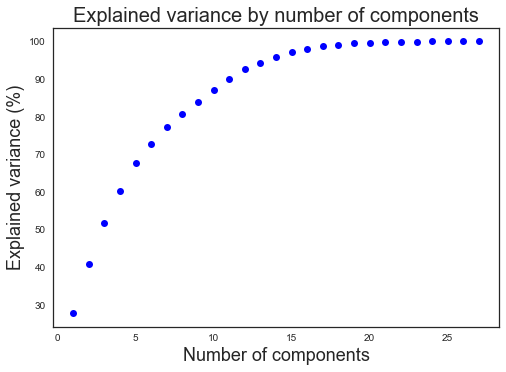

In [22]:
#show explained variance vs. number of components 
        
plt.plot(np.arange(1,28), cum_exp_vars, 'bo')
plt.title('Explained variance by number of components')
plt.ylabel('Explained variance (%)')
plt.xlabel('Number of components')
plt.show()

Taking a look at this graph, we decide to choose 7 components. Up to 7 components, there is an increase in nearly $5\%$ of explained variance for each added component. From thereon out, there is an increase of at most $3.2\%$ per added component. Thus, we refit our PCA keeping only 7 components. We then transform the '16-'17 and '17-'18 team stats data with this PCA.

In [23]:
#keep 7 components of PCA
pca_7_cmpts = PCA(n_components=7)

#fit to '16-'17 team stats 
pca_7_cmpts.fit(num_team_stats_17)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
#transform '16-'17 data with PCA
trans_team_stats_17 = pca_7_cmpts.transform(num_team_stats_17)

print(trans_team_stats_17[:5,:])

[[ 13.53453478   5.51631331  -1.13660531  -2.63949273  13.72566492
    8.67040281   9.6123234 ]
 [ 23.09692345   3.12953012  -3.62833886  -8.64071273   5.85362753
   -1.45805605   7.24771778]
 [ -9.73472441  -0.79819802  -9.47428293   3.44144949 -15.62674146
    4.64057604   0.12676498]
 [ -0.91666302   2.31034488   2.38162282  17.40806354   7.21900084
   -7.56778085  -8.28616351]
 [ -1.92306746  -5.00359034 -20.02121558  11.76205974   1.51233409
   -0.93575378  -5.42171315]]


In [25]:
#transform '17-'18 data with fitted PCA
trans_team_stats_18 = pca_7_cmpts.transform(num_team_stats_18)

print(trans_team_stats_18[:5,:])

[[ -9.21208135   6.43969861   6.75123229   1.32140268   4.5737346
    6.41954322   2.24248551]
 [ -5.89133478   5.98885311  14.59923074  -4.75233311  -3.22786478
   -8.56044896   3.98742498]
 [ -5.94596548  16.56336655 -17.39193115   9.54207732  -6.22091119
    2.87568094   0.68674379]
 [  3.75321666  -2.01285899  12.3651308   -3.88470519 -12.98996558
   -4.985422    -4.9606924 ]
 [-12.15593883  -2.02581442   4.89616589  23.80831192   4.28039771
   -2.25734981  -5.24036988]]


## Classification with transformed '16-'17 and '17-'18 team stats data

We will now apply several classification methods to our transformed data, keeping track of training time and accuracy. 

We train our data on $70\%$ of the '16-'17 team stats data. We then use the model to classify the testing '16-'17 data and _all_ of the '17-'18 data. We start by splitting the data and use the same split when employing all the methods. We will stratify according to wins and losses, so there are the same proportions of winning and losing teams in the training and testing data. We will also fix a random state for reproducibility.

In [26]:
from sklearn.model_selection import train_test_split

#split '16-'17 transformed team stats with 30% for testing 
x_train_17, x_test_17, y_train_17, y_test_17 = train_test_split(trans_team_stats_17, \
                                                                team_stats_17.loc[:,'won'],\
                                                                test_size=0.3, \
                                                                stratify=team_stats_17.loc[:,'won'],\
                                                                random_state=23)

### Logistic regression 

We begin by classifying with logistic regression.

In [34]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()

#fit logistic regression to '16-'17 data
#high value for C to reduce regularization

model = LogisticRegression(C=1E6, random_state=23)
lr_model = model.fit(x_train_17, y_train_17)
predicted = lr_model.predict(x_test_17)


print('Training took ' + str(time.time() - start_time) + ' seconds.')

Training took 0.007702827453613281 seconds.


In [35]:
lr_model.coef_

array([[ 0.08877499, -0.01662198, -0.01186136,  0.03955985,  0.0060935 ,
        -0.07715132, -0.1081168 ]])

In [36]:
from sklearn.metrics import accuracy_score, classification_report

lr_score = 100.0 * accuracy_score(y_test_17,predicted)

print("Logistic regression score for '16-'17 data: {0:4.1f}%\n".format(lr_score))

print(classification_report(y_test_17,predicted))

Logistic regression score for '16-'17 data: 79.0%

             precision    recall  f1-score   support

          0       0.80      0.78      0.79       393
          1       0.78      0.80      0.79       393

avg / total       0.79      0.79      0.79       786



$79\%$ accuracy is a nice baseline for prediction, especially considering how quick it took to train our Logistic Regression model. __Remember that the all spam method (classifying all games as wins) would be accurate at $50\%$.__ 

We now check how accurate this model is for classifying wins for all games during the '17-'18 season. We will find that it is $76\%$ accurate.

In [29]:
predicted_18 = lr_model.predict(trans_team_stats_18)

lr_score_18 = 100.0 * accuracy_score(team_stats_18.loc[:,'won'], predicted_18)

print("Logistic regression score for '17-'18 data: {0:4.1f}%\n".format(lr_score_18))

print(classification_report(team_stats_18.loc[:,'won'], predicted_18))

Logistic regression score for '17-'18 data: 76.3%

             precision    recall  f1-score   support

          0       0.76      0.77      0.76      1312
          1       0.76      0.76      0.76      1312

avg / total       0.76      0.76      0.76      2624



### Decision tree classification

We will now run the same process using decision trees.

In [30]:
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()

dtc = DecisionTreeClassifier(random_state=23)

dtc = dtc.fit(x_train_17, y_train_17)

predicted = dtc.predict(x_test_17)

print('Training decision tree classifier took ' + str(time.time() - start_time) + ' seconds.')

Training decision tree classifier took 0.023926973342895508 seconds.


In [31]:
dtc_score = 100.0 * accuracy_score(y_test_17,predicted)

print("Decision tree score for '16-'17 data: {0:4.1f}%\n".format(dtc_score))

print(classification_report(y_test_17,predicted))

Decision tree score for '16-'17 data: 67.2%

             precision    recall  f1-score   support

          0       0.68      0.66      0.67       393
          1       0.67      0.68      0.68       393

avg / total       0.67      0.67      0.67       786



In [ ]:
predicted_18 = dtc.predict(trans_team_stats_18)

dtc_score_18 = 100.0 * accuracy_score(team_stats_18.loc[:,'won'], predicted_18)

print("Decision tree score for '17-'18 data: {0:4.1f}%\n".format(dtc_score_18))

print(classification_report(team_stats_18.loc[:,'won'], predicted_18))

Decision tree score for '17-'18 data: 65.6%

             precision    recall  f1-score   support

          0       0.66      0.65      0.65      1312
          1       0.65      0.66      0.66      1312

avg / total       0.66      0.66      0.66      2624



We find that using a base model for a Decision Tree Classifier predicts the '16-17 testing data with $67\%$ accuracy and the '17-'18 games with $65\%$. It also takes a split second to train the decision tree classifier.

### Support vector machine classification

We now employ a Support Vector Machine with linear kernel for classification. I suspect that it will take longer, but be more accurate.

In [ ]:
from sklearn.svm import SVC

start_time = time.time()

svc_model = SVC(kernel='linear', C=1E6, random_state=23)
svc_model = svc_model.fit(x_train_17, y_train_17)
predicted = svc_model.predict(x_test_17)

print('Training SVC took ' + str(time.time() - start_time) + ' seconds.')


In [ ]:
svc_score = 100.0 * accuracy_score(y_test_17,predicted)

print("SVC score for '16-'17 data: {0:4.1f}%\n".format(svc_score))

print(classification_report(y_test_17,predicted))

In [ ]:
predicted_18 = svc_model.predict(trans_team_stats_18)

svc_score_18 = 100.0 * accuracy_score(team_stats_18.loc[:,'won'], predicted_18)

print("SVC score for '17-'18 data: {0:4.1f}%\n".format(svc_score_18))

print(classification_report(team_stats_18.loc[:,'won'], predicted_18))

We find that the Support Vector Classification works with similar accuracy as Logistic Regression. The main difference is that it took around 1 hour 50 minutes to train the Support Vector Classifier while it took less than 1 second to train the Logistic Regressor.

### Classification with Random forests

While classifying with Decision Trees had very fast training speed, it was much less accurate than classifying with Logistic Regression and Support Vector Classifiers. It may be that employing many Decision Trees in the form of Random Forest may be more accurate.



In [ ]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()

rfc = RandomForestClassifier(n_estimators=10, max_features='auto', \
                            min_samples_split=2, random_state=23)

#Fit to '16-'17 data
rfc = rfc.fit(x_train_17, y_train_17)

print('Training Random Forest Classifier took ' + str(time.time() - start_time) + ' seconds.')


In [ ]:
rfc_score = 100.0 * rfc.score(x_test_17, y_test_17)

print("Random Forest Classifier score for '16-'17 data: {0:4.1f}%\n".format(rfc_score))

In [ ]:
rfc_score_18 = 100.0 * rfc.score(trans_team_stats_18, team_stats_18.loc[:,'won'])

print("Random Forest Classifier score for '17-'18 data: {0:4.1f}%\n".format(rfc_score_18))

We find that the Random Forest Classifier is slightly less accurate than classifying with Logistic Regression and the Support Vector Classifier. It is still very fast with split second speed to train.

### Gradient Tree Boosting

We continue to use decision trees, but in a slightly different way with boosting. We will test classification with Gradient Tree Boosting.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

gbtc = GradientBoostingClassifier(n_estimators=500, max_depth=3, random_state=23)

#fit to '16-'17 team stats
gbtc = gbtc.fit(x_train_17, y_train_17)

print('Training Gradient Boosting Classifier took ' + str(time.time() - start_time) + ' seconds.')

In [ ]:
gbtc_score = 100.0 * gbtc.score(x_test_17, y_test_17)

print("Gradient Boosting Classifier score for '16-'17 data: {0:4.1f}%\n".format(gbtc_score))

In [ ]:
gbtc_score_18 = 100.0 * gbtc.score(trans_team_stats_18, team_stats_18.loc[:,'won'])

print("Gradient Boosting Classifier score for '17-'18 data: {0:4.1f}%\n".format(gbtc_score_18))

Using Gradient Boosting had slightly improved performance in terms of accuracy over using a Random Forest. While it took just over a second to train, Gradient Boosting took over 100 times longer than Logistic Regression to train.

### k-Nearest Neighbors classifier

We will now use a bit more intuitive classifier: the k-Nearest Neighbors Classifier. Recall that it labels new data by considering the labels of nearby training points. Unfortunately, it fails under the _curse of dimensionality_: our data has too many features (7) relative to the number of data points (around 2000). For this reason, we will classify according to the first 4 principal components.

In [ ]:
from sklearn import neighbors

start_time = time.time()

#number of neighbors
nbrs=10

knc = neighbors.KNeighborsClassifier(n_neighbors=nbrs)

#train model with best 4 principal components of '16-'17 data
knc = knc.fit(x_train_17[:,:4], y_train_17)

print('Training K-nearest Neighbors Classifier took ' + str(time.time() - start_time) + ' seconds.')

In [ ]:
knc_score = 100.0 * knc.score(x_test_17[:,:4], y_test_17)

print("K-nearest Neighbors Classifier score for '16-'17 data: {0:4.1f}%\n".format(knc_score))

In [ ]:
knc_score_18 = 100.0 * knc.score(trans_team_stats_18[:,:4], team_stats_18.loc[:,'won'])

print("K-nearest Neighbors Classifier score for '17-'18 data: {0:4.1f}%\n".format(knc_score_18))

While the training speed is just low as any other method, the accuracy is a few percentage points lower than others.

### Voting Classification

We have tested several machine learning methods of classification in this notebook. We will conclude by seeing what happens when we combine a few of the methods by the way of Voting Classification. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

start_time = time.time()

#input estimators
clf1 = KNeighborsClassifier(n_neighbors=5)
clf2 = LogisticRegression(random_state=23)
clf3 = RandomForestClassifier(random_state=23, max_depth=10)

#create list of tuples, matching names to input estimator
est_list = [('knn', clf1), ('lr', clf2), ('rfc', clf3)]

#soft voting- classifying based on summed classification probs
vclf = VotingClassifier(estimators=est_list, voting='soft') 

#fit to '16-'17 team stats
vclf = vclf.fit(x_train_17, y_train_17)

print('Training Voting Classifier took ' + str(time.time() - start_time) + ' seconds.')

In [ ]:
vclf_score = 100.0 * vclf.score(x_test_17, y_test_17)

print("Voting Classifier score for '16-'17 data using K-NN, Logistic Regression, and Random Forest: {0:4.1f}%\n".format(vclf_score))

In [ ]:
vclf_score_18 = 100.0 * vclf.score(trans_team_stats_18, team_stats_18.loc[:,'won'])

print("Voting Classifier score for '17-'18 data using K-NN, Logistic Regression, and Random Forest: {0:4.1f}%\n".format(vclf_score_18))

The voting classifier performs similarly to the Support Vector Classifier. The training time is still sub-second.

## Summary

In this notebook, we applied a Principal Component Analysis with the team stats from the 2016-17 NBA season. We used the elbow method to decide to keep the 7 most important components, which explained $77.2\%$ of the variance. We then transformed the 2017-18 team stats data using this fitted PCA. 

We then applied several different machine learning classification methods on this data. We trained the methods on the same $70\%$ of the '16-'17 data. The methods worked with varying training speed and accuracy, summarized as fellows.

Each item describes a method, its training time, its accuracy in classifying '16-'17 data, and its accuracy in classifying '17-'18 data.

- __Logistic Regression__, Training time: $0.007$ sec, '16-'17 classification: $79.0\%$, '17-'18 classification: $76.3\%$
- __Decision Tree__, TT: $0.014$ sec, '16-'17: $67.2\%$, '17-'18: $65.6\%$ 
- __Support Vector Machine__, TT: $1$ hr $25$ min, '16-'17: $77.7\%$, '17-'18: $75.0\%$ 
- __Random Forest__, TT: $0.046$ sec, '16-'17: $73.4\%$, '17-'18: $70.5\%$
- __Gradient Tree Boosting__, TT: $0.934$ sec, '16-'17: $75.2\%$, '17-'18: $72.3\%$
- __k-Nearest Neighbors (k-NN)__, TT: $0.004$ sec, '16-'17: $70.5\%$, '17-'18: $68.8\%$
- __Voting (k-NN, Log. Reg., $\&$ Ran. For.)__, TT: $0.049$ sec, '16-'17: $76.3\%$, '17-'18: $75.0\%$

The best method surprisingly was the first one we used: simple Logistic Regression. It had the best accuracy for both seasons and had the second fastest training time clocking in at nearly a hundredth of a second.

More work can be done on why Logistic Regression performed the best, what happens when we include more components, and which stats are most influential towards winning.

## Applying Logistic Regression to all '16-'17 and '17-'18 team stats

We will conclude by applying Logistic Regression to all of the team stats from the '16-'17 and '17-'18 seasons. Recall we applying a PCA, keeping 7 components, to the '16-'17 team stats. We then applied Logistic Regression to the transformed stats, keeping in mind that the 7 kept components only explained $77.2\%$ of the variance. As Logistic Regression was very quick, we will apply it to all 27 original team stats.

Recall that all of the team stats for the '16-'17 season, '17-'18 season were stored in the DataFrames `num_team_stats_17`, `num_team_stats_18`, respectively.

In [54]:
#scale stats
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

scaled_team_stats_17 = ss.fit_transform(num_team_stats_17)

In [55]:
#train/test split keeping 30% for testing
x_train_all_17, x_test_all_17, y_train_all_17, y_test_all_17 = train_test_split(scaled_team_stats_17, \
                                                                team_stats_17.loc[:,'won'],\
                                                                test_size=0.3, \
                                                                stratify=team_stats_17.loc[:,'won'],\
                                                                random_state=23)

In [56]:
start_time = time.time()

#fit logistic regression to '16-'17 data
#high value for C to reduce regularization

model = LogisticRegression(C=1E6, random_state=23)
lr_model = model.fit(x_train_all_17, y_train_all_17)
predicted = lr_model.predict(x_test_all_17)


print('Training took ' + str(time.time() - start_time) + ' seconds.')

Training took 0.020262956619262695 seconds.


In [57]:
lr_score_all = 100.0 * accuracy_score(y_test_all_17,predicted)

print("Logistic regression score for '16-'17 data: {0:4.1f}%\n".format(lr_score_all))

print(classification_report(y_test_all_17,predicted))

Logistic regression score for '16-'17 data: 85.6%

             precision    recall  f1-score   support

          0       0.85      0.87      0.86       393
          1       0.86      0.85      0.85       393

avg / total       0.86      0.86      0.86       786



In [59]:
scaled_team_stats_18 = ss.transform(num_team_stats_18)

predicted_all_18 = lr_model.predict(scaled_team_stats_18)

lr_score_all_18 = 100.0 * accuracy_score(team_stats_18.loc[:,'won'], predicted_all_18)

print("Logistic regression score for '17-'18 data: {0:4.1f}%\n".format(lr_score_all_18))

print(classification_report(team_stats_18.loc[:,'won'], predicted_all_18))

Logistic regression score for '17-'18 data: 86.5%

             precision    recall  f1-score   support

          0       0.86      0.87      0.87      1312
          1       0.87      0.86      0.86      1312

avg / total       0.87      0.87      0.87      2624



We find that Logistic Regression increases $6.6\%$, $10.2\%$ in accuracy as one jumps from 7 components to all of the stats. Also the training time is still negligible. (Training the support vector machine would have taken many more hours if we used all of the stats.) More work could be done on tuning parameters and studying how accurate by team Logistic Regression is for classification.

In [63]:
print(x_train_all_17[:5,:])

[[ 0.41688052 -0.61934365 -2.0525845  -0.29465002 -1.2840194  -0.60582956
   0.8007094  -1.15543126 -1.05278059 -0.61388156 -1.01606215 -0.97172923
  -0.98910084 -0.21401101 -0.07803193  1.30581308 -1.00133946 -0.87427577
   0.10550518 -0.29989376 -0.23554674 -0.17997629 -0.77934438 -0.98924872
   0.72396807 -0.74217101 -0.21985949]
 [ 0.07730578  1.2913     -0.35522633 -0.12485171  0.36025901  0.79971956
  -0.18358095  0.99184439 -1.05278059 -0.31645546 -1.23898388  0.02007862
  -0.43615059  1.27977904  0.06009355  1.0387335   0.13285727 -0.87427577
  -0.23976052  1.31558333 -0.23554674 -0.83735742 -0.02355701  1.29805635
  -0.22584321  2.68665904 -0.21985949]
 [-0.09248158  1.46499488  0.32371693 -0.9738433   0.27804509  1.60289048
  -0.32419385  1.99143822 -0.76863837 -0.46516851 -0.68698721 -1.63293446
  -1.68028864 -0.44305881 -0.76865933 -1.09790316  0.51092284  1.40735303
  -0.93029193  0.10397551 -0.49302539 -0.34432157  1.79033267  1.71392999
  -0.70074885 -0.74217101 -0.21985

In [65]:
stat_names = num_team_stats_17.columns

#print stat coefficients for logistic regression model
lr_model.coef_[0].shape

for idx in range(lr_model.coef_[0].shape[0]):
    print(stat_names[idx] + ": " + str(lr_model.coef_[0][idx]))

first_qtr_points: -0.538699100835
second_qtr_points: -0.319201609699
third_qtr_points: -0.403940537035
fourth_qtr_points: -0.434598873306
total_points: 0.535053450833
fg_made: 0.0659175613375
fg_attempted: -1.83704895207
fg_percentage: 2.61177592628
threept_made: 1.41336855504
threept_attempted: -0.504471750254
threept_percentage: -0.23410415145
ft_made: 0.145024118824
ft_attempted: -0.411488228682
ft_percentage: 1.02300760874
total_rebounds: 2.84425542736
offensive_rebounds: 0.318922408825
defensive_rebounds: 0.350712088839
assists: 0.220924195317
steals: 1.57475399029
blocks: 0.267842632473
total_turnovers: -1.4329338255
points_off_turnovers: -0.556252671857
fast_break_points: 0.0330336668253
points_in_paint: 0.0177644493222
personal_fouls: -0.179615917507
technical_fouls: -0.340721983532
flagrant_fouls: -0.0747243925594
